<a href="https://colab.research.google.com/github/beaten-by-the-market/dart_disclosure/blob/main/dart_xml_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## OpenDart에서 사업보고서 제출 공시 불러오기
[OpenDartReader패키지 깃허브링크](https://github.com/FinanceData/OpenDartReader)

In [ ]:
import pandas as pd
import time
from datetime import datetime
import requests
from bs4 import BeautifulSoup
import re
from tqdm.notebook import tqdm
import random
import difflib
import logging
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
import pickle
from google.colab import userdata

In [ ]:
!pip install opendartreader
import OpenDartReader

#OpenDartReader 연결
dart = OpenDartReader(userdata.get('opendart_personal')) # colab에서 제공하는 비번 저장기능사용

### 날짜리스트 생성

In [ ]:
#날짜리스트 생성
date_pairs = [('2025-02-01', '2025-04-30')]
print(date_pairs)

[('2025-02-01', '2025-04-30')]


### 공시 불러오기

In [ ]:
# 공시 불러오기 함수
def fetch_disclosures(date_pairs, kind_detail='A001', max_retries=3, base_delay=10):
    """
    API를 통해 공시 데이터를 가져오는 함수

    Args:
        date_pairs: 시작일과 종료일 튜플의 리스트
        kind_detail: 공시 유형 코드
        max_retries: 최대 재시도 횟수
        base_delay: 기본 대기 시간(초)

    Returns:
        수집된 데이터 DataFrame
    """
    disc = pd.DataFrame()
    retry_pairs = []

    # 첫 번째 시도
    for st, end in tqdm(date_pairs, desc="API 요청 진행 중"):
        try:
            print(f"기간: {st} ~ {end} 데이터 요청 중...")
            df_loop = dart.list(kind_detail=kind_detail, start=st, end=end, final=False)

            # 결과가 비어있는지 확인
            if df_loop is None or df_loop.empty:
                print(f"데이터 없음: {st} ~ {end}")
            else:
                disc = pd.concat([disc, df_loop], ignore_index=True)
                print(f"성공: {len(df_loop)}개 데이터 추가됨")

            # API 호출 사이에 지연 추가 (10-15초 랜덤 지연)
            delay = base_delay + random.uniform(0, 5)
            time.sleep(delay)

        except Exception as e:
            print(f"오류 발생: {st} ~ {end}, 원인: {str(e)}")
            retry_pairs.append((st, end, 1))  # 재시도 횟수를 1로 시작
            # 오류 발생 시 더 오래 대기 (15-20초)
            time.sleep(base_delay + 10 + random.uniform(0, 5))

    # 재시도 로직
    if retry_pairs:
        print(f"\n재시도 필요한 요청: {len(retry_pairs)}개")

        with tqdm(total=len(retry_pairs), desc="재시도 진행 중") as pbar:
            while retry_pairs:
                st, end, retry_count = retry_pairs.pop(0)

                if retry_count > max_retries:
                    print(f"최대 재시도 횟수 초과: {st} ~ {end}, 건너뜀")
                    pbar.update(1)
                    continue

                try:
                    print(f"재시도 {retry_count}/{max_retries}: {st} ~ {end}")
                    df_loop = dart.list(kind_detail=kind_detail, start=st, end=end, final=False)

                    if df_loop is None or df_loop.empty:
                        print(f"데이터 없음: {st} ~ {end}")
                    else:
                        disc = pd.concat([disc, df_loop], ignore_index=True)
                        print(f"성공: {len(df_loop)}개 데이터 추가됨")

                    pbar.update(1)

                    # 성공 후 지연 (12-18초 랜덤 지연)
                    delay = base_delay + 2 + random.uniform(0, 6)
                    time.sleep(delay)

                except Exception as e:
                    print(f"재시도 오류: {st} ~ {end}, 원인: {str(e)}")
                    # 재시도 횟수 증가
                    retry_pairs.append((st, end, retry_count + 1))
                    # 오류 후 더 긴 지연 (15-25초)
                    time.sleep(base_delay + 10 + random.uniform(0, 10))

    # 오늘 날짜 설정
    today = datetime.today().strftime('%Y%m%d')
    disc['last_update'] = today

    print(f"최종 데이터 수집 완료: {len(disc)}개 레코드")
    return disc

# 함수 실행
disc = fetch_disclosures(date_pairs)

API 요청 진행 중:   0%|          | 0/1 [00:00<?, ?it/s]

기간: 2025-02-01 ~ 2025-04-30 데이터 요청 중...
성공: 3786개 데이터 추가됨
최종 데이터 수집 완료: 3786개 레코드


### 코스피 상장법인 최근 10개 사업보고서

In [ ]:
# 코스피 상장법인 최근 10개
disc_y = disc[(disc['corp_cls'] == 'Y')&
              ~(disc['report_nm'].str.startswith('[첨부정정]'))&
              ~(disc['corp_name'].str.contains('리츠'))].drop_duplicates(subset='corp_code', keep='first').reset_index(drop = True).head(10)
disc_y

,corp_code,corp_name,stock_code,corp_cls,report_nm,rcept_no,flr_nm,rcept_dt,rm,last_update
0,01009789,코스맥스,192820,Y,[기재정정]사업보고서 (2024.12),20250416000526,코스맥스,20250416,연,20250417
1,00171265,파라다이스,034230,Y,[기재정정]사업보고서 (2024.12),20250415000021,파라다이스,20250415,연,20250417
2,00146214,일성아이에스,003120,Y,[첨부추가]사업보고서 (2024.12),20250313000824,일성아이에스,20250313,정,20250417
3,00141404,영풍제지,006740,Y,[기재정정]사업보고서 (2024.12),20250411003513,영풍제지,20250411,연,20250417
4,01133217,카카오뱅크,323410,Y,[기재정정]사업보고서 (2024.12),20250411001905,카카오뱅크,20250411,,20250417
5,00155258,포스코스틸리온,058430,Y,[기재정정]사업보고서 (2024.12),20250408001924,포스코스틸리온,20250408,연,20250417
6,00469799,이엔플러스,074610,Y,사업보고서 (2024.12),20250407004328,이엔플러스,20250407,연,20250417
7,00163716,한창,005110,Y,사업보고서 (2024.12),20250407003120,한창,20250407,연,20250417
8,00125974,삼부토건,001470,Y,사업보고서 (2024.12),20250407003073,삼부토건,20250407,연,20250417
9,00164973,현대해상,001450,Y,[기재정정]사업보고서 (2024.12),20250407001731,현대해상,20250407,연,20250417


### 파라다이스 예시
[파라다이스사업보고서 링크](https://dart.fss.or.kr/dsaf001/main.do?rcpNo=20250415000021)

In [ ]:
# 파라다이스 예시 XML 불러오기
xml_text = dart.document('20250415000021')
xml_text[:2000]

### 구글드라이브에 저장해놓기

In [ ]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')
# 저장 경로 설정
file_path = '/content/drive/MyDrive/rag_projects/dart_xml_example_paradise.txt'

# 파일 저장
with open(file_path, 'w', encoding='utf-8') as f:
    f.write(xml_text)

## XML에서 특정 태그의 내용 불러오기

### 구글드라이브에서 불러오기

In [ ]:
# 불러오기 경로 설정
file_path = '/content/drive/MyDrive/rag_projects/dart_xml_example_paradise.txt'

# 파일 읽기
with open(file_path, 'r', encoding='utf-8') as f:
    xml_text = f.read()

# 결과 확인
print(xml_text[:500])

<?xml version="1.0" encoding="utf-8"?>


<DOCUMENT xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:noNamespaceSchemaLocation="dart4.xsd">

<DOCUMENT-NAME ACODE="11011">사업보고서</DOCUMENT-NAME>
<FORMULA-VERSION ADATE="20241231">6.1</FORMULA-VERSION>
<COMPANY-NAME AREGCIK="00171265">주식회사 파라다이스</COMPANY-NAME>

<SUMMARY>
<EXTRACTION ACODE="LINK_FLAG" AFEATURE="BOTH">C</EXTRACTION>
<EXTRACTION ACODE="FIN_TYPE" AFEATURE="BOTH">A</EXTRACTION>
<EXTRACTION ACODE="IFRS_YN" AFEATURE="BOTH">Y</EXTRAC


### 어떤 XML 태그들이 있는지 살펴보기

In [ ]:
# beautifulsoup 파서로 처리
soup = BeautifulSoup(xml_text, 'xml')

# 딕셔너리 변환 예시
data_dict = {}
for element in soup.find_all():
    if element.text.strip():
        data_dict[element.name] = element.text.strip()

# 태그값들 확인
unique_tags = set(tag.name for tag in soup.find_all(True))
unique_tags

{'A',
 'BODY',
 'COL',
 'COLGROUP',
 'COMPANY-NAME',
 'CORRECTION',
 'COVER',
 'COVER-TITLE',
 'DOCUMENT',
 'DOCUMENT-NAME',
 'EXTRACTION',
 'FORMULA-VERSION',
 'IMAGE',
 'IMG',
 'IMG-CAPTION',
 'LIBRARY',
 'P',
 'PGBRK',
 'SECTION-1',
 'SECTION-2',
 'SECTION-3',
 'SPAN',
 'SUMMARY',
 'TABLE',
 'TABLE-GROUP',
 'TBODY',
 'TD',
 'TE',
 'TH',
 'THEAD',
 'TITLE',
 'TR',
 'TU',
 '보수지급금액',
 '이사ㆍ감사'}

### 특정태그를 확인해보기

In [ ]:
# 특정 태그의 모든 발생 횟수 확인
tag_name = 'TABLE-GROUP'
occurrences = [element.text.strip() for element in soup.find_all(tag_name) if element.text.strip()]
print(f"'{tag_name}' 태그 개수: {len(occurrences)}")

# 특정 텍스트를 포함한 table-group 태그 찾기
result = []
for tg in soup.find_all(tag_name):
    if '주요 논의 내용' in tg.get_text():
        result.append(tg)

# 결과 출력 (확인용)
for tg in result:
    print(tg.prettify())

'TABLE-GROUP' 태그 개수: 137
<TABLE-GROUP ACLASS="DIS_CUS" ADELETETABLE="N">
 <TABLE ACLASS="EXTRACTION" AFIXTABLE="N" BORDER="1" WIDTH="894">
  <COLGROUP WIDTH="894">
   <COL WIDTH="48"/>
   <COL WIDTH="137"/>
   <COL WIDTH="283"/>
   <COL WIDTH="63"/>
   <COL WIDTH="363"/>
  </COLGROUP>
  <THEAD>
   <TR ACOPY="N" ADELETE="N" HEIGHT="30">
    <TH ACOPYCOL="N" ADELETECOL="N" AMOVECOL="N" AUPDATECONT="N" ENG="Category" HEIGHT="23" VALIGN="MIDDLE" WIDTH="39">
     구분
    </TH>
    <TH ACOPYCOL="N" ADELETECOL="N" AMOVECOL="N" AUPDATECONT="N" ENG="Date" HEIGHT="23" VALIGN="MIDDLE" WIDTH="128">
     일자
    </TH>
    <TH ACOPYCOL="N" ADELETECOL="N" AMOVECOL="N" AUPDATECONT="N" ENG="Attendees" HEIGHT="23" VALIGN="MIDDLE" WIDTH="274">
     참석자
    </TH>
    <TH ACOPYCOL="N" ADELETECOL="N" AMOVECOL="N" AUPDATECONT="N" ENG="Method" HEIGHT="23" VALIGN="MIDDLE" WIDTH="54">
     방식
    </TH>
    <TH ACOPYCOL="N" ADELETECOL="N" AMOVECOL="N" AUPDATECONT="N" ENG="Key discussions" HEIGHT="23" VALIGN="MIDDL

### HTML 태그와 비교하기
* XML : "DIS_CUS"라는 테이블을 식별할 수 있는 태그가 있습니다.<br>TABLE-GROUP ACLASS="DIS_CUS" ADELETETABLE="N"
* HTML : TABLE 태그만 있을 뿐, 테이블을 특정할 수 있는 태그가 없습니다.

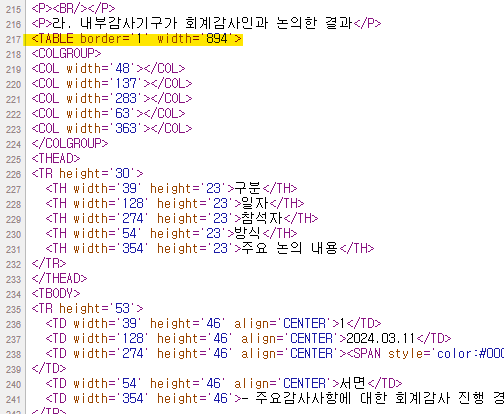

### 내부감사기구가 회계감사인의 소통내역 테이블 불러오기

In [ ]:
# 특정 속성을 가진 TABLE-GROUP 찾기
table_group = soup.find('TABLE-GROUP', attrs={"ACLASS": "DIS_CUS", "ADELETETABLE": "N"})

# 헤더 추출 (THEAD 내의 TH 태그들에서)
headers = [th.get_text(strip=True) for th in table_group.find('THEAD').find_all('TH')]

# 데이터 추출 (TBODY 내의 TR 태그들에서)
rows = []
for tr in table_group.find('TBODY').find_all('TR'):
    row_data = []
    # 각 TR 내의 TE, TU 태그에서 텍스트 추출
    for cell in tr.find_all(['TE', 'TU']):
        # 여러 SPAN 태그가 있을 경우 텍스트를 공백으로 연결
        if cell.find_all('SPAN'):
            cell_text = ' '.join(span.get_text(strip=True) for span in cell.find_all('SPAN'))
        else:
            cell_text = cell.get_text(strip=True)
        row_data.append(cell_text)
    rows.append(row_data)

# DataFrame 생성
df = pd.DataFrame(rows, columns=headers)

In [ ]:
df

,구분,일자,참석자,방식,주요 논의 내용
0,1,2024.03.11,"회사측 : 회계세무팀장, 감사 감사인 : 업무수행이사, 필드책임회계사",서면,- 주요감사사항에 대한 회계감사 진행 경과- 통제테스트 및 기중 감사절차 진행 경과 등
1,2,2024.05.26,"회사측 : 회계세무팀장, 감사위원회감사인 : 업무수행이사, 필드책임회계사",서면,- 1분기 재무제표 검토결과 논의- 주요 수행절차 및 그룹감사 소개- 감사인의 독립성 등
2,3,2024.08.29,"회사측 : 회계세무팀장, 감사위원회감사인 : 업무수행이사, 필드책임회계사",대면회의,- 반기 재무제표 검토결과 논의- 연결내부회계관리제도 업무계획 등
3,4,2024.11.21,"회사측 : 회계세무팀장, 감사위원회감사인 : 업무수행이사, 필드책임회계사",대면회의,- 3분기 재무제표 검토결과 논의- 주요 기말감사 및 내부회계관리제도감사 계획- 기...
4,5,2024.03.12,"회사측 : 회계세무팀장, 감사위원회감사인 : 업무수행이사, 필드책임회계사",대면회의,- 주요감사사항에 대한 회계감사 진행 경과- 별도 및 연결내부회계관리제도 진행 경과 등
